In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [56]:
data = pd.read_csv('data.csv')

In [57]:
def compute_new_angle(prev_angle,
                      acceleration,
                      angular_velocity,
                      time_step=1.0/20.0,
                      beta=0.98):
    new_angle = beta * (prev_angle + angular_velocity * time_step) + (1.0 - beta) * np.arcsin(acceleration)
    return new_angle

In [58]:
def compute_angle_series(acceleration,
                         angular_velocity,
                         init_angle=0.0,
                         time_step=1.0/20.0):
    angle_series = []
    prev_angle = init_angle
    for index in range(len(acceleration)):
        new_angle = compute_new_angle(prev_angle=prev_angle,
                                      acceleration=acceleration[index],
                                      angular_velocity=angular_velocity[index],
                                      time_step=time_step)
        angle_series.append(new_angle)
        prev_angle = new_angle
    return np.array(angle_series)

In [68]:
accel_df = data[['accelerometerX', 'accelerometerY']].copy()
accel_df.rename(columns={'accelerometerX': 'x',
                         'accelerometerY': 'y'},
                inplace=True)
# de-biasing step
accel_df = accel_df - np.mean(accel_df)

In [71]:
accel_estimate_x = np.arcsin(accel_df['x'])
accel_estimate_y = np.arcsin(accel_df['y'])

In [69]:
gyro_df = data[['gyroscopeX', 'gyroscopeY']].copy()
gyro_df.rename(columns={'gyroscopeX': 'x',
                        'gyroscopeY': 'y'},
               inplace=True)
# de-biasing step
gyro_df = gyro_df - np.mean(gyro_df)

In [85]:
time_delta = 1.0 / 20.0
# We have to swap x and y here because rotation around the x axis
# correpsonds to a tilt in the y plane and vice versa
gyro_estimate_x = np.cumsum(gyro_df['y'] * time_delta)
gyro_estimate_y = np.cumsum(gyro_df['x'] * time_delta)

In [86]:
combined_estimate_x = compute_angle_series(accel_df['x'], gyro_df['y'])
combined_estimate_y = compute_angle_series(accel_df['y'], gyro_df['x'])

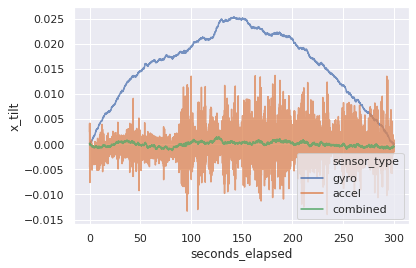

In [88]:
x_data = pd.DataFrame({
    'gyro': gyro_estimate_x,
    'accel': accel_estimate_x,
    'combined': combined_estimate_x,
    'seconds_elapsed': np.arange(6000) * 1.0/20.0,
})
x_data = pd.melt(x_data, id_vars=['seconds_elapsed'], var_name='sensor_type', value_name='x_tilt')
sns.lineplot(x='seconds_elapsed', y='x_tilt', hue='sensor_type', data=x_data, alpha=0.75)

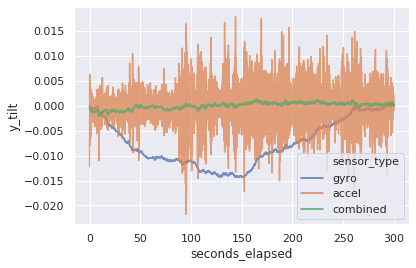

In [89]:
y_data = pd.DataFrame({
    'gyro': gyro_estimate_y,
    'accel': accel_estimate_y,
    'combined': combined_estimate_y,
    'seconds_elapsed': np.arange(6000) * 1.0/20.0,
})
y_data = pd.melt(y_data, id_vars=['seconds_elapsed'], var_name='sensor_type', value_name='y_tilt')
sns.lineplot(x='seconds_elapsed', y='y_tilt', hue='sensor_type', data=y_data, alpha=0.75)